In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.algorithms.linear_solvers.hhl import HHL
from math import pi, atan
from pprint import pprint
from matplotlib import pyplot
from random import randint

# 1. Setup

In [2]:
def qsvm_circuit(train, theta, dot_val):
    q = QuantumRegister(5, name="x")
    c = ClassicalRegister(2, name="c")
    qc = QuantumCircuit(q, c)

    qc.u(-1.57, 0, 0, q[2])    # qc.u3(-1.57, 0, 0, q[2])

    qc.barrier()

    qc.h(q[0])
    qc.h(q[1])

    qc.barrier()

    qc.p(3.17, q[0])    # qc.u1(3.17, q[0])
    qc.p(1.59, q[1])    # qc.u1(1.59, q[1])
    # qc.cu3(pi, pi/2, -pi/2, q[0], q[2])
    qc.cu(2*dot_val*pi, pi/2, -pi/2, 0, q[0], q[2])
    # qc.cu3(pi/2, pi/2, -pi/2, q[1], q[2])
    qc.cu(dot_val*pi, pi/2, -pi/2, 0, q[1], q[2])

    qc.barrier()

    qc.h(q[1])
    qc.cp(-pi/2, q[0], q[1])    # qc.cu1(-pi/2, q[0], q[1])
    qc.h(q[0])

    qc.barrier()

    qc.cry(pi/4, q[0], q[3])
    qc.cry(pi/8, q[1], q[3])

    qc.barrier()

    qc.h(q[0])
    qc.cp(pi/2, q[0], q[1])    # qc.cu1(pi/2, q[0], q[1])
    qc.h(q[1])

    qc.barrier()

    qc.p(-1.59, q[0])
    qc.p(-3.17, q[1])
    # qc.cu3(-pi/2, pi/2, -pi/2, q[0], q[2])
    qc.cu(-dot_val*pi, pi/2, -pi/2, 0, q[0], q[2])
    # qc.cu3(-pi, pi/2, -pi/2, q[1], q[2])
    qc.cu(-2*dot_val*pi, pi/2, -pi/2, 0, q[1], q[2])

    qc.barrier()

    qc.h(q[0])
    qc.h(q[1])

    qc.barrier()

    qc.x(q[2])
    qc.ccx(q[2], q[3], q[4])
    qc.x(q[2])
    qc.cry(train[0], q[4], q[1])
    qc.x(q[2])
    qc.ccx(q[2], q[3], q[4])
    qc.x(q[2])

    qc.barrier()

    qc.ccx(q[2], q[3], q[4])
    qc.cry(train[1], q[4], q[1])
    qc.ccx(q[2], q[3], q[4])

    qc.barrier()

    qc.cry(-theta, q[3], q[1])
    qc.ch(q[3], q[2])

    qc.barrier()

    qc.h(q[3])
    qc.measure(q[3], c[0])
    qc.h(q[0])
    qc.measure(q[0], c[1])

    return qc

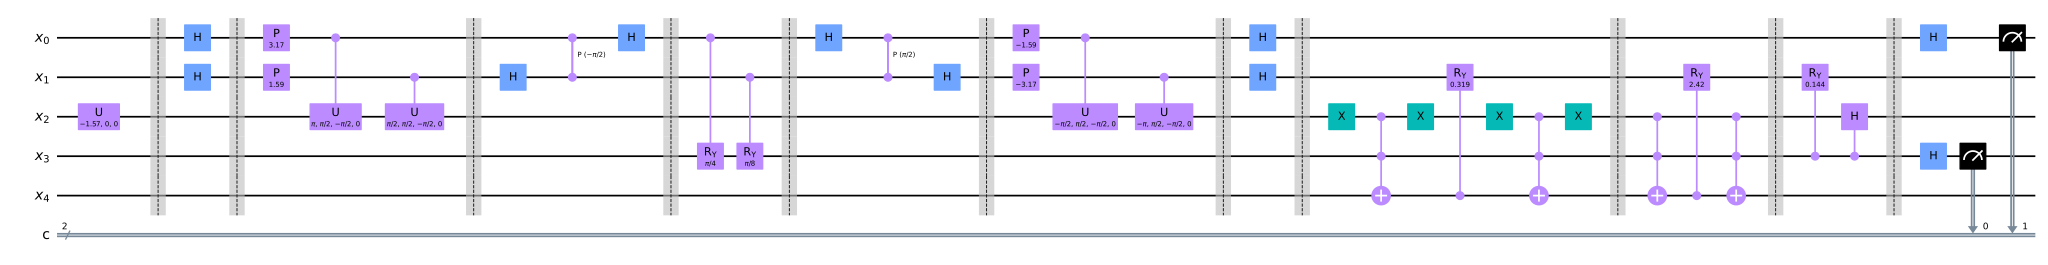

In [3]:
qc = qsvm_circuit([0.3194, 2.4174], -0.14415, 0.5)
qc.draw(fold=-1)

In [4]:
def getMatchPercent(x, y):
    l = len(x)
    if len(y) != l:
        raise Exception('ERR at getMatch, len(x) != len(y)')
    ctr = 0
    for i in range(l):
        if (x[i] == y[i]):
            ctr += 1
    return(ctr/l*100)

# 2. Reproduce the paper's 6/9 experiment

In [5]:
training = [0.3194, 2.4174]
testing = [-0.14415, 2.4519, 2.8465, 0.0499, -0.05998, 2.2331, -0.32316, 2.7939]
label = [6, 9, 9, 6, 6, 9, 6, 9]
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, 0.5)
    simulator = Aer.get_backend('qasm_simulator')

    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(6)
    else:
        outcome.append(9)

print(label)
print(outcome)
print(getMatchPercent(outcome, label), end='%\n')

[6, 9, 9, 6, 6, 9, 6, 9]
[6, 9, 9, 6, 6, 9, 6, 9]
100.0%


# 3. Extend the experiment
### After the success in reproducing the experiment on the paper, we want to know if it also applies to a different dataset. Below are the $\alpha$s and $\beta$s collected from MNIST.

In [6]:
alphabeta = {
    0: [
        [0.3163115312630537, -0.9486553721926747],
        [0.9956521206912666, 0.09314963533467721],
        [0.2424761686211572, -0.9701573623133538],
        [0.3090424127497972, 0.9510482569889835],
        [0.9773397149232854, 0.21167683301124735],
        [-0.3038216268790871, -0.9527289326143847],
        [-0.9288552206622026, -0.3704429497892635],
        [0.8890107669572688, -0.4578862918171375],
        [0.9333055286224707, -0.35908326366280346],
    ],
    1: [
        [0.9763896637352572, -0.2160167228502261],
        [0.806600328933814, 0.5910972080494571],
        [0.7763459862791707, -0.6303069963027713],
        [-0.855661373182786, -0.517536099651946],
        [-0.8460177656724315, -0.5331547056592739],
        [-0.9439951322734825, -0.32995937665714276],
        [-0.9700968519911586, -0.24271814467988231],
        [-0.9137110293651945, -0.4063645590063147],
        [0.8931667653449796, 0.44972561555151175],
    ],
    2: [
        [-0.5661859690353817, -0.8242775312159527],
        [0.5626231718140011, -0.8267134730594107],
        [0.9999974263469661, -0.0022687660619699064],
        [0.19294971609044437, -0.9812086460384544],
        [-0.4924989003614522, -0.8703130661680085],
        [0.4046489578449499, -0.914472099582593],
        [0.598140693741117, -0.8013911095656696],
        [-0.287362826027438, -0.9578218029558131],
        [-0.20985870525100697, -0.9777317238539266],
    ],
    3: [
        [-0.992418961484461, 0.12290079286198233],
        [-0.800215876385337, 0.5997120568913443],
        [0.9255632364473354, 0.37859304713258246],
        [0.23745563680981938, 0.971398384056327],
        [-0.8865842727098362, 0.46256710581662697],
        [0.08440278394911564, 0.9964317187151556],
        [0.5536508274235685, 0.8327489185181798],
        [-0.7622528778553873, 0.6472793447972676],
        [-0.9663744829337596, 0.2571387927452972],
    ],
    4: [
        [0.9321515342921673, 0.36206838734796815],
        [0.8683049749661503, -0.4960307152274273],
        [0.05087353811806258, -0.9987051031807888],
        [-0.9886702518000559, -0.15010374147773234],
        [-0.860657807201803, -0.5091837967793008],
        [-0.9844752997143146, -0.175523172978415],
        [0.9534060888437391, 0.3016899563387624],
        [0.890099082554819, 0.45576707124919597],
        [0.9740422631312452, 0.22636622900548095],
    ],
    5: [
        [0.18190616974339316, 0.9833158929913053],
        [0.5311375808957558, -0.847285589491645],
        [-0.7794727288990287, -0.6264361618734197],
        [-0.17257861280284734, 0.9849957474035332],
        [-0.49470579248057495, -0.8690605150886596],
        [-0.9905599318894655, 0.13708034627596172],
        [0.7881927891606716, 0.615428409415036],
        [0.9998826676305028, 0.01531832145208842],
        [0.9039018478221851, -0.42773993208916006],
    ],
    6: [
        [-0.9869874274557179, -0.1607974441474243],
        [-0.20062068065628783, -0.979668996392663],
        [0.80413127759967, -0.5944517544645004],
        [0.7321555225009626, -0.681137497772177],
        [0.4973617833238433, -0.8675432303285678],
        [0.44377795385765406, -0.8961367795542787],
        [-0.6724179591245482, -0.7401716613372721],
        [0.25367598743933034, -0.967289250119467],
        [-0.16293524868467188, -0.9866367643343036],
    ],
    7: [
        [-0.7305810341620098, 0.6828260045742021],
        [-0.12852025185802873, 0.9917068845492345],
        [-0.5359399693838656, -0.8442560922000037],
        [-0.6630248398067302, 0.748597396334812],
        [-0.8439721538372243, 0.5363869904717644],
        [-0.5460432874565954, 0.8377569625038002],
        [-0.5171272581896644, 0.8559085224702697],
        [-0.16183342395536623, 0.9868180900707499],
        [0.43305157678359085, 0.9013691429404745],
    ],
    8: [
        [0.2134811637630681, 0.9769471801066658],
        [-0.9209221660661163, 0.3897465382118133],
        [0.6638967103348526, 0.7478242828409363],
        [0.9862173766909255, 0.16545478510115413],
        [0.8871918751931753, -0.46140066817378717],
        [-0.015475780753977639, 0.99988024293415],
        [0.9966053716213816, -0.0823269898357007],
        [0.9995743616732166, -0.029173540847516746],
        [0.6815848536671074, 0.7317390841355871],
    ],
    9: [
        [-0.6330182566824322, 0.7741368656166263],
        [0.997551898820124, 0.06993003046163304],
        [-0.8501501932010538, -0.5265402634179184],
        [-0.5035919705323636, -0.863941622573731],
        [-0.9599524856611257, 0.280162854913042],
        [-0.6861091497860836, 0.7274986148301711],
        [-0.44589010916660154, -0.8950877110917097],
        [-0.532697509280275, 0.8463057152156019],
        [0.9969088132301219, 0.078567283929825],
    ],
}

## Calculate the $\theta$ values

In [7]:
theta_data = {}
for key, val in alphabeta.items():
    theta_data[key] = []
    for x in val:
        theta_data[key].append(2 * atan(x[1] / x[0]))
pprint(theta_data)

{0: [-2.4979149495529183,
     0.18656974336897708,
     -2.6517578989370993,
     2.5132206697178225,
     0.42658070692900446,
     2.5241899634184866,
     0.7589717049611155,
     -0.951232285994755,
     -0.734570921680823],
 1: [-0.4354660372070874,
     1.2648369020043069,
     -1.3638971711978436,
     1.0879378147797945,
     1.124650182209078,
     0.6725210828124676,
     0.4903336089897937,
     0.8369435213384107,
     0.9329162224564916],
 2: [1.9378499695707234,
     -1.9464818559509451,
     -0.004537536016621592,
     -2.753257713996653,
     2.111675265459499,
     -2.308402805787905,
     -1.8592346616700115,
     2.558647867962427,
     2.7187317641571003],
 3: [-0.24642461919315953,
     -1.2862824569347788,
     0.7765514369526246,
     2.6621011932377017,
     -0.9617770398419444,
     2.972586016757834,
     1.9681087563429118,
     -1.4080195490831728,
     -0.5201205337831849],
 4: [0.7409717575864841,
     -1.038042945151683,
     -3.039801637271883,
     0.3

# 4. Result

In [8]:
extended_result = {}

In [9]:
n1, n2 = 0, 1

tr1, tr2 = 0, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0/1 : 56.25%


In [10]:
n1, n2 = 0, 2

tr1, tr2 = 1, 1
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
0/2 : 50.0%


In [11]:
n1, n2 = 0, 3

tr1, tr2 = 6, 1
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0/3 : 50.0%


In [12]:
n1, n2 = 0, 4

tr1, tr2 = 7, 2
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0/4 : 62.5%


In [13]:
n1, n2 = 0, 5

tr1, tr2 = 8, 6
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
0/5 : 50.0%


In [14]:
n1, n2 = 0, 6

tr1, tr2 = 0, 6
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
0/6 : 37.5%


In [15]:
n1, n2 = 0, 7

tr1, tr2 = 3, 3
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0/7 : 50.0%


In [16]:
n1, n2 = 0, 8

tr1, tr2 = 3, 3
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
0/8 : 56.25%


In [17]:
n1, n2 = 0, 9

tr1, tr2 = 3, 5
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0/9 : 50.0%


In [18]:
n1, n2 = 1, 2

tr1, tr2 = 6, 7
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
1/2 : 43.75%


In [19]:
n1, n2 = 1, 3

tr1, tr2 = 4, 4
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1/3 : 50.0%


In [20]:
n1, n2 = 1, 4

tr1, tr2 = 2, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
1/4 : 37.5%


In [21]:
n1, n2 = 1, 5

tr1, tr2 = 1, 8
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
1/5 : 43.75%


In [22]:
n1, n2 = 1, 6

tr1, tr2 = 2, 8
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
1/6 : 43.75%


In [23]:
n1, n2 = 1, 7

tr1, tr2 = 1, 1
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
1/7 : 37.5%


In [24]:
n1, n2 = 1, 8

tr1, tr2 = 0, 8
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
1/8 : 25.0%


In [25]:
n1, n2 = 1, 9

tr1, tr2 = 6, 5
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1/9 : 50.0%


In [26]:
n1, n2 = 2, 3

tr1, tr2 = 0, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2/3 : 62.5%


In [27]:
n1, n2 = 2, 4

tr1, tr2 = 7, 5
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
2/4 : 68.75%


In [28]:
n1, n2 = 2, 5

tr1, tr2 = 4, 1
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
2/5 : 56.25%


In [29]:
n1, n2 = 2, 6

tr1, tr2 = 2, 4
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
2/6 : 50.0%


In [30]:
n1, n2 = 2, 7

tr1, tr2 = 5, 2
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
2/7 : 31.25%


In [31]:
n1, n2 = 2, 8

tr1, tr2 = 5, 6
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
2/8 : 50.0%


In [32]:
n1, n2 = 2, 9

tr1, tr2 = 1, 1
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1]
2/9 : 50.0%


In [33]:
n1, n2 = 3, 4

tr1, tr2 = 3, 6
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
3/4 : 56.25%


In [34]:
n1, n2 = 3, 5

tr1, tr2 = 7, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]
3/5 : 50.0%


In [35]:
n1, n2 = 3, 6

tr1, tr2 = 2, 2
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
3/6 : 50.0%


In [36]:
n1, n2 = 3, 7

tr1, tr2 = 3, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
3/7 : 56.25%


In [37]:
n1, n2 = 3, 8

tr1, tr2 = 6, 6
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
3/8 : 43.75%


In [38]:
n1, n2 = 3, 9

tr1, tr2 = 4, 2
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]
3/9 : 37.5%


In [39]:
n1, n2 = 4, 5

tr1, tr2 = 0, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
4/5 : 68.75%


In [40]:
n1, n2 = 4, 6

tr1, tr2 = 6, 3
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
4/6 : 50.0%


In [41]:
n1, n2 = 4, 7

tr1, tr2 = 5, 3
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
4/7 : 50.0%


In [42]:
n1, n2 = 4, 8

tr1, tr2 = 6, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
4/8 : 56.25%


In [43]:
n1, n2 = 4, 9

tr1, tr2 = 3, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
4/9 : 50.0%


In [44]:
n1, n2 = 5, 6

tr1, tr2 = 4, 4
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
5/6 : 43.75%


In [45]:
n1, n2 = 5, 7

tr1, tr2 = 6, 1
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
5/7 : 50.0%


In [46]:
n1, n2 = 5, 8

tr1, tr2 = 2, 1
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
5/8 : 50.0%


In [47]:
n1, n2 = 5, 9

tr1, tr2 = 1, 6
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
5/9 : 37.5%


In [48]:
n1, n2 = 6, 7

tr1, tr2 = 5, 2
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
6/7 : 37.5%


In [49]:
n1, n2 = 6, 8

tr1, tr2 = 5, 6
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]
6/8 : 56.25%


In [50]:
n1, n2 = 6, 9

tr1, tr2 = 0, 0
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
6/9 : 50.0%


In [51]:
n1, n2 = 7, 8

tr1, tr2 = 1, 1
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]
7/8 : 50.0%


In [52]:
n1, n2 = 7, 9

tr1, tr2 = 8, 8
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

        
print(label)
print(outcome)
print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]
7/9 : 68.75%


In [53]:
n1, n2 = 8, 9

tr1, tr2 = 0, 5
training = [theta_data[n1][tr1], theta_data[n2][tr2]]
testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
    alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
label = [0]*8 + [1]*8
outcome = []

for theta in testing:
    qc = qsvm_circuit(training, theta, dot_val)
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=8192)
    result = job.result().get_counts()
    result = {key[1]: val for key, val in result.items() if key[0] == '0'}
    if result['0'] > result['1']:
        outcome.append(0)
    else:
        outcome.append(1)

print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
8/9 : 50.0%


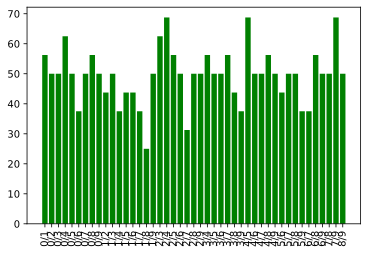

In [54]:
keys = extended_result.keys()
vals = extended_result.values()
pyplot.bar(list(keys), vals, color='g')
pyplot.xticks(range(len(list(keys))), list(keys), rotation='vertical')
pyplot.show()

{'0/1': 56.25, '0/2': 50.0, '0/3': 50.0, '0/4': 56.25, '0/5': 50.0, '0/6': 50.0, '0/7': 50.0, '0/8': 56.25, '0/9': 43.75, '1/2': 31.25, '1/3': 31.25, '1/4': 50.0, '1/5': 62.5, '1/6': 31.25, '1/7': 68.75, '1/8': 37.5, '1/9': 37.5, '2/3': 43.75, '2/4': 56.25, '2/5': 56.25, '2/6': 43.75, '2/7': 25.0, '2/8': 56.25, '2/9': 62.5, '3/4': 56.25, '3/5': 43.75, '3/6': 50.0, '3/7': 31.25, '3/8': 43.75, '3/9': 43.75, '4/5': 50.0, '4/6': 31.25, '4/7': 43.75, '4/8': 43.75, '4/9': 37.5, '5/6': 37.5, '5/7': 62.5, '5/8': 37.5, '5/9': 50.0, '6/7': 56.25, '6/8': 50.0, '6/9': 50.0, '7/8': 75.0, '7/9': 62.5, '8/9': 56.25}


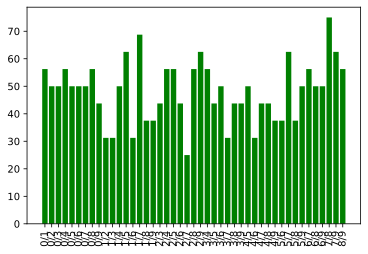

In [55]:
extended_result = {}

for n1 in range(10):
    for n2 in range(n1 + 1, 10):

        tr1, tr2 = randint(0,8), randint(0,8)
        training = [theta_data[n1][tr1], theta_data[n2][tr2]]
        testing = theta_data[n1][0:tr1] + theta_data[n1][tr1+1:] + theta_data[n2][0:tr2] + theta_data[n2][tr2+1:]
        dot_val = alphabeta[n1][tr1][0] * alphabeta[n2][tr2][0] + \
            alphabeta[n1][tr1][1] * alphabeta[n2][tr2][1]
        label = [0]*8 + [1]*8
        outcome = []

        for theta in testing:
            qc = qsvm_circuit(training, theta, dot_val)
            simulator = Aer.get_backend('qasm_simulator')
            job = execute(qc, simulator, shots=8192)
            result = job.result().get_counts()
            result = {key[1]: val for key, val in result.items() if key[0] == '0'}
            if result['0'] > result['1']:
                outcome.append(0)
            else:
                outcome.append(1)

#         print('{}/{} : {}%'.format(n1, n2, getMatchPercent(outcome, label)))
        extended_result['{}/{}'.format(n1, n2)] = getMatchPercent(outcome, label)

print(extended_result)

In [56]:
keys = extended_result.keys()
vals = extended_result.values()
pyplot.bar(list(keys), vals, color='g')
pyplot.xticks(range(len(list(keys))), list(keys), rotation='vertical')
pyplot.show()

48.19444444444444
